
# Getting started with HCIPy

## II - Wavefronts and optical systems

First let's import HCIPy, and a few supporting libraries:

In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Wavefronts in HCIPy are monochromatic. They consist of an electric field (as an HCIP `Field`), and a wavelength. If broadband images are needed, multiple `Wavefront`s must be constructed and propagated through the optical system, sampling the required wavelength range. Let us construct a `Wavefront`.

In [2]:
pupil_grid = make_pupil_grid(1024)
aperture = circular_aperture(1)(pupil_grid)

wavefront = Wavefront(aperture, 1)

A note must be made at this point regarding units. HCIPy is averse w.r.t. the used units. If the user fills in all quantities in SI, then all calculations in HCIPy will be returned in SI units. This allows the user to use any unit he/she wants, while still being able to seamlessly use dimensionless quantities. Ie. the convention that is used in this document, is that if the diameter of the aperture is 1, the wavelength is 1, and the focal length is 1 as well, then the focal-plane will be given in $\lambda/D$.

To propagate this wavefront to the focal plane, we first need to construct a grid on which the focal plane will be sampled:

In [3]:
focal_grid = make_focal_grid(pupil_grid, 8, 16)

This constructs a `Grid` with 8 samples per $\lambda/D$ and a 32 $\lambda/D$ radius field of view. Now we can construct a Fraunhofer propagator that can actually propagate the light to the focal plane.

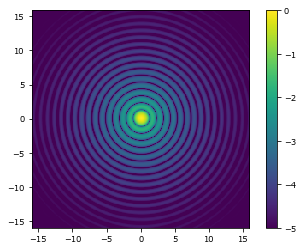

In [4]:
prop = FraunhoferPropagator(pupil_grid, focal_grid)

img = prop.forward(wavefront)

imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-5)
plt.colorbar()
plt.show()

All Fourier transforms concerning the propagation are done internally. In this case a Matrix Fourier transform was used, as it was deemed quicker than a Fast Fourier transform in this case. Also note that when defining the propagator, we didn't pass the wavelength of the wavefront. This wavelength is taken from the `Wavefront` object during the propagation.

Also note that a `Wavefront` supports many properties to make it easier to use. One that we used above is `Wavefront.intensity`, but others exist as well: for example `Wavefront.phase` and `Wavefront.amplitude`, which yield the phase and amplitude of the electric field respectively. All these properties are returned as `Field`s, and can therefore be shown using `imshow_field()`.

For a more interesting results, let's do a propagation with physical quantities. We calculate the intensity pattern of a circular aperture with a diameter of 1cm, after a free-space propagation of 2m, at a wavelength of 500nm.

In [5]:
pupil_grid_2 = make_pupil_grid(1024, 0.015)
aperture_2 = circular_aperture(0.01)(pupil_grid_2)

fresnel_prop = FresnelPropagator(pupil_grid_2, 1e-3)

wf = Wavefront(aperture_2, 500e-9)
img = prop(wf)

#imshow_field(img.phase)
#plt.colorbar()
#plt.show()

The propagators shown previously are part of a larger group of optical elements. All `OpticalElement`s can propagate a `Wavefront` through them. Examples include simple `Apodizer`s, which act as an infinitely-thin screen with a (complex) transmission. A little more complicated example is `SurfaceAberration`, which simulates a surface error with a power-law PSD (power spectral density). Optical elements can be linked to represent more complicated optical systems.

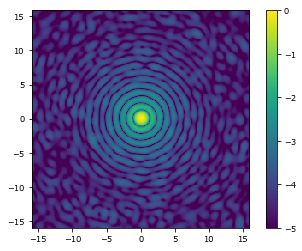

In [6]:
aberration = SurfaceAberration(pupil_grid, 1/4, 1)

wf = Wavefront(aperture)
img = prop(aberration(wf))

imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-5)
plt.colorbar()
plt.show()

These simple optical elements can be combined into more complicated optical systems. These include full wavefront sensor implementations and coronagraphs. Both of these will be handled in later sections.

To convert a `Wavefront` into an observed image, one can simply use the `Wavefront.power` attribute, which is the `Wavefront.intensity` multiplied by the weight at each pixel. If one wants to use a more complicated detector model, HCIPy supplies a `Detector` class. and its derivatives. A detector uses an integration/readout scheme:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


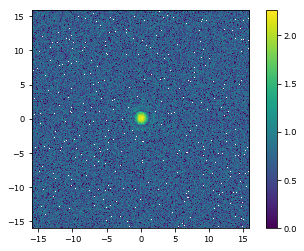

In [7]:
flat_field = 0.01
dark = 10
detector = NoisyDetector(focal_grid, dark_current_rate=dark, flat_field=flat_field)

wf.total_power = 1000
img = prop(aberration(wf))

detector.integrate(img, 0.5)
image = detector.read_out()

imshow_field(np.log10(image), vmax=np.log10(image).max(), vmin=0)
plt.colorbar()
plt.show()